# Influenza Predictor Exploration/Overview

Lucas Nguyen 
UCSD

Description:

The goal of this project is to create a module of functions that automate the Data Science process. The functions in the module are designed to replace often repeated data science tasks so users don't have to repeat the same actions each time they analyze a new dataset. We keep principles of abstraction so the module can be applied to a variety of DS tasks.



We explore several paths for creating an Influenza Predictor from time and (geography?) associated web data, which will require the following steps:
1. Determining Locations with accessible data
   - Prediction Side i.e. indicators to predict influenza outbreak
       1. Google Trends API
       [link1](https://support.google.com/trends/answer/4365533?hl=en)
       [link2](https://medium.com/google-news-lab/what-is-google-trends-data-and-what-does-it-mean-b48f07342ee8)
        - search terms to query
            - Symptoms related to flu
            - Use word-embeddings to determine words related to flu
                - Word2vec
                    - too local
                - GLove
                    - Captures Global presence
            - Google shopping for flu medicine
            - Related searches when look up "influenza"
       2. Twitter API
            - need developer account
            - PREMIUM FOR ACCESS BEYOND 7 DAYS >:(
   - Output Side i.e. actual influenza data
       1. CDC FluView:
           - Locations
               - state 2010-present
               - census divisions 1997-present
               - HHS regions 1997-present
           - Statistics
               - % ILI visits by location
               - Influenza positive tests
               
2. Explore trends in data
    - Stationarity
    - F-test compare models
        - sarima
    - Auto-correlation
    - Tripe Exponential Smoothing

               
2. Determine Model to create Predictor
    - ARIMAs
    - Seq2Seq w/ Attention
    - LSTM 
    
               
    
   

[BRAINSTORMED PATHS]

## Word2Vec

First we try Word2vec trained on the Wikipedia Text8 corpus [link]. 

It appears the Wikipedia Corpus does not make any good suggestions for search terms with relation to the flu.

import gensim
from gensim.models import word2vec
import logging

assert gensim.models.doc2vec.FAST_VERSION > -1

## Google Trends Analysis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import functions as f

In [4]:
cdc_df = pd.read_csv('data/fv2/ILINet.csv', skiprows=1)

In [5]:
ca_df = pd.read_csv('data/ca2.csv', skiprows=2)

In [6]:
f.head_n(ca_df, 3, 20, 30)

,Month,influenza: (California),flu: (California)
30,2006-07,1,4
33,2006-10,1,16
36,2007-01,1,10
39,2007-04,1,4
42,2007-07,<1,3
45,2007-10,1,13
48,2008-01,1,8
51,2008-04,1,4
54,2008-07,1,2
57,2008-10,1,12


In [7]:
ca_df.columns

Index(['Month', 'influenza: (California)', 'flu: (California)'], dtype='object')

In [8]:
def fix_ca_index(x):
    year, month = x.split('-')
    if len(month) < 2:
        month = '0' + month
    string = year + '-' + month
    return dt.strptime(string, '%Y-%m').strftime('%Y-%m')

def ca_str_to_int(x): # define function to convert string to int
    if x == '<1':
        return 0
    else:
        return int(x)

In [9]:
ca_df.index = map(fix_ca_index, ca_df['Month'])
ca_df.drop(['Month'], axis=1, inplace=True)

In [10]:
pd.Series(map(ca_str_to_int, ca_df.iloc[:, 1][::10])) # test
ca_df = ca_df.applymap(ca_str_to_int)
ca_df[::19]

,influenza: (California),flu: (California)
2004-01,1,9
2005-08,1,4
2007-03,1,5
2008-10,1,12
2010-05,1,3
2011-12,1,9
2013-07,0,3
2015-02,1,12
2016-09,1,11
2018-04,1,9


In [11]:
cdc_df.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,California,2010,40,X,1.95412,X,X,X,X,X,X,632,112,32342
1,States,California,2010,41,X,2.15266,X,X,X,X,X,X,742,122,34469
2,States,California,2010,42,X,2.24173,X,X,X,X,X,X,766,126,34170
3,States,California,2010,43,X,1.91748,X,X,X,X,X,X,666,130,34733
4,States,California,2010,44,X,2.52326,X,X,X,X,X,X,887,131,35153


ideas: 
- nan % vals for all columns
- histogram of values?
- histogram of column values compared to missing values in another column

(478, 15)


,YEAR,WEEK,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,2014.828452,26.884937,2.302335,864.131799,109.493724,36828.098326
std,2.657190,15.107211,1.080121,483.683301,24.066796,9150.398445
min,2010.000000,1.000000,0.553292,91.000000,66.000000,14858.000000
25%,2013.000000,14.000000,1.536655,473.000000,88.000000,30286.500000
50%,2015.000000,27.000000,2.010755,767.000000,113.000000,35905.000000
75%,2017.000000,40.000000,2.862268,1091.000000,127.750000,44234.000000
max,2019.000000,53.000000,6.842450,2512.000000,165.000000,57086.000000


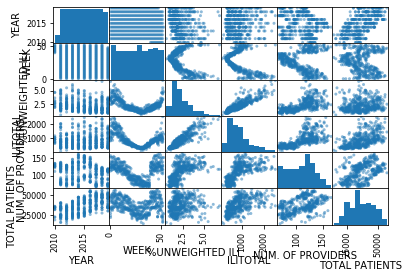

In [12]:
# functions:

def head_n(df, i=1, n=5, s=0):
    '''
    Show up to n rows of df in intervals of i starting
    from index s. This is useful for dataframes such as 
    time series where we want to see values every i rows.
    
    Arguments:
    i(int) = interval to skip by
    n(int) = number of rows to display
    s(int) = starting row
    '''
    # doctest i n s
    # make class where df attribute of self?
    return df.iloc[s:n*i:i, :]

def explore_dataframe(df):
    print(df.shape)
    pd.plotting.scatter_matrix(df)
    return df.describe()

def imputer(df, col, func=np.median):
    '''
    Function which imputes values using either mean, median,
    or custom function i.e. lambda x: 0
    WARNING: function replaces values of DataFrame column in place
    
    Arguments:
    df(DataFrame) = DataFrame object to be operated on
    col(str) = string referencing column in DataFrame to index
    func(Function) = Function to determine value that is imputed
    '''
    value = func(df[col])
    df[col] = df[col].fillna(val, inplace=True)
    

explore_dataframe(cdc_df)
#cdc_df.describe()

In [13]:
cdc_df['Date'] = cdc_df.apply(lambda x: dt.strptime(str(x[2])+str(x[3])+'-1', '%Y%U-%w'), axis=1)
cdc_df['Month'] = cdc_df['Date'].apply(lambda x: x.month)
cdc_df.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,Date,Month
0,States,California,2010,40,X,1.95412,X,X,X,X,X,X,632,112,32342,2010-10-04,10
1,States,California,2010,41,X,2.15266,X,X,X,X,X,X,742,122,34469,2010-10-11,10
2,States,California,2010,42,X,2.24173,X,X,X,X,X,X,766,126,34170,2010-10-18,10
3,States,California,2010,43,X,1.91748,X,X,X,X,X,X,666,130,34733,2010-10-25,10
4,States,California,2010,44,X,2.52326,X,X,X,X,X,X,887,131,35153,2010-11-01,11


In [14]:
def fix_cdc_index(row):
    y, m = row[0], row[1]
    date_str = str(y) + '-' + str(m)
    return fix_ca_index(date_str)

In [15]:
cdc_df_clean = pd.DataFrame(cdc_df[['ILITOTAL', 'YEAR', 'Month']].groupby(['YEAR', 'Month'])['ILITOTAL'].sum())#group months
cdc_df_clean.reset_index(inplace=True) # reset needed for apply
cdc_df_clean.index = cdc_df_clean.apply(fix_cdc_index, axis=1) #format like ca_df
cdc_df_clean.head()

,YEAR,Month,ILITOTAL
2010-10,2010,10,2806
2010-11,2010,11,4481
2010-12,2010,12,4215
2011-01,2011,1,7383
2011-02,2011,2,7805


In [16]:
date_range = min(cdc_df['Date']), max(cdc_df['Date'])
date_range

(Timestamp('2010-10-04 00:00:00'), Timestamp('2019-12-02 00:00:00'))

In [87]:
merged_df = cdc_df_clean.join(ca_df)
merged_df.drop(['YEAR', 'Month'], axis=1, inplace=True)
col1, col2 = merged_df.columns[1], merged_df.columns[2]
merged_df.rename({'ILITOTAL': 'Visits', col1: 'Influenza', col2: 'Flu'}, axis=1, inplace=True)
merged_df.head()

,Visits,Influenza,Flu
2010-10,2806,1,9
2010-11,4481,1,6
2010-12,4215,1,6
2011-01,7383,1,9
2011-02,7805,1,11


In [88]:
merged_df.corr()

,Visits,Influenza,Flu
Visits,1.000000,0.712261,0.607899
Influenza,0.712261,1.000000,0.851349
Flu,0.607899,0.851349,1.000000


In [89]:
import seaborn as sns

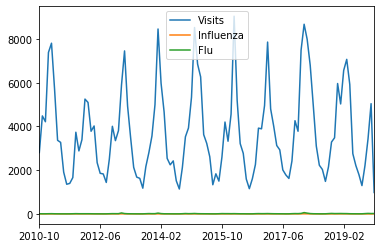

In [90]:
merged_df.plot()

In [91]:
def normalize(series):
    '''
    Takes a Series as input and applies
    min-max normalizaiton
    '''
    minimum = min(series)
    maximum = max(series)
    return series.apply(lambda x: (x - minimum)/(maximum - minimum))

In [92]:
merged_df['Visits'] = normalize(merged_df['Visits'])
merged_df['Influenza'] = normalize(merged_df['Influenza'])
merged_df['Flu'] = normalize(merged_df['Flu'])

merged_df.head()

,Visits,Influenza,Flu
2010-10,0.226607,0.2,0.103448
2010-11,0.434475,0.2,0.051724
2010-12,0.401464,0.2,0.051724
2011-01,0.794614,0.2,0.103448
2011-02,0.846984,0.2,0.137931


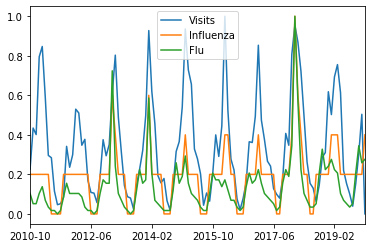

In [93]:
merged_df.plot()

In [94]:
#fig = plt.figure()
#ax = plt.axes()
#plt.plot(merged_df['Visits'])

In [95]:
merged_df['date'] = list(map(lambda x: dt.strptime(x, '%Y-%m'), merged_df.index))
merged_df['year'] = list(map(lambda x: x.year, merged_df['date']))
merged_df.head()

,Visits,Influenza,Flu,date,year
2010-10,0.226607,0.2,0.103448,2010-10-01,2010
2010-11,0.434475,0.2,0.051724,2010-11-01,2010
2010-12,0.401464,0.2,0.051724,2010-12-01,2010
2011-01,0.794614,0.2,0.103448,2011-01-01,2011
2011-02,0.846984,0.2,0.137931,2011-02-01,2011


In [98]:
merged_df.groupby('year').agg('max')

,Visits,Influenza,Flu,date
year,,,,
2010,0.434475,0.2,0.103448,2010-12-01
2011,0.846984,0.2,0.155172,2011-12-01
2012,0.529908,0.2,0.172414,2012-12-01
2013,0.803301,0.6,0.724138,2013-12-01
2014,0.927650,0.6,0.586207,2014-12-01
2015,0.935964,0.4,0.293103,2015-12-01
2016,1.000000,0.4,0.206897,2016-12-01
2017,0.853438,0.4,0.344828,2017-12-01
2018,0.954579,1.0,1.000000,2018-12-01
